# Binary Classification

## Accuracy and SGD
Usually (when using techniques like Decision Trees) we use `accuracy` (number_of_correct_guesses/total_guesses) to determine how well our classification model is performing. However, this doesn't work for neural networks. SGD needs a loss function that changes smoothly, where as `accuracy` will change it jumps (as its a ratio)

Instead we use cross entropy

### Cross Entropy
Cross Entropy gives us a measure of distance from on probability distribution to another. This works as the model predicts as when the model predicts high probability (p ≈ 1) for a positive example (y = 1), the loss is low because -log(p) ≈ 0
when the model predicts low probability (p ≈ 0) for a positive example (y = 1), the loss is high because -log(p) → ∞ *

*This is because neural networks output probability-like numbers for classes. You set one class as the "positive" class (1) and another as "negative" (0). **This presumes a single-class classification problem.

## Sigmoid Function
A Sigmoid function is an activation function that normalises real numbers between 0 and 1:
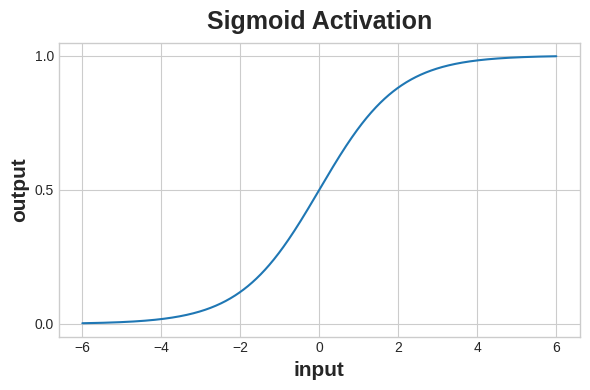
We put this after the final layer, this gives us a sensible decision boundary as >0.5 = the positive class.

# Important Note
At the heart of it - a binary classification model is just a regression model, with a different loss function (Cross Entropy instead of MAE) and a sigmoid activation layer at the end.

Epoch 1/200


/Users/natedev/repos/machine-learning/.venv/lib/python3.9/site-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.7412 - loss: 0.5401 - val_binary_accuracy: 0.7947 - val_loss: 0.4340
Epoch 2/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.8014 - loss: 0.4254 - val_binary_accuracy: 0.8128 - val_loss: 0.4054
Epoch 3/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.8056 - loss: 0.4117 - val_binary_accuracy: 0.8135 - val_loss: 0.4000
Epoch 4/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_accuracy: 0.8113 - loss: 0.4045 - val_binary_accuracy: 0.8151 - val_loss: 0.3958
Epoch 5/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.8165 - loss: 0.3941 - val_binary_accuracy: 0.8216 - val_loss: 0.3898
Epoch 6/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.8129 - loss: 0.3962 - val_binary_accuracy: 0.8226 - val_loss: 0.3862
Epoch 7/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.8204 - loss: 0.3878 - val_binary_accuracy: 0.8242 - val_loss: 0.3844
Epoch 8/200

<Axes: title={'center': 'Accuracy'}>

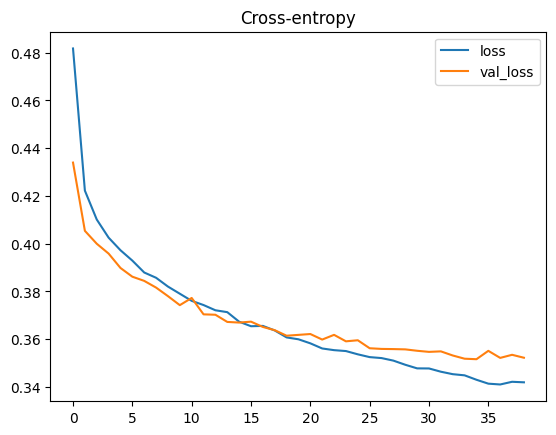

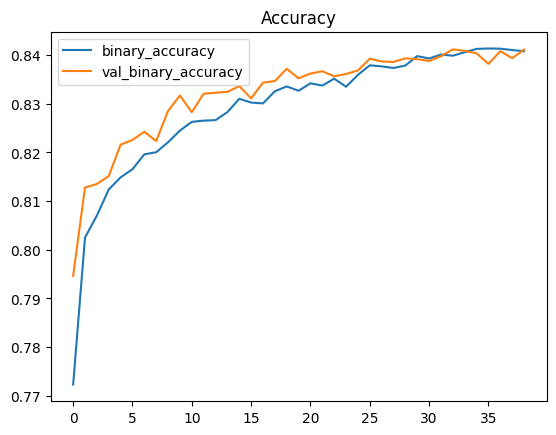

In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from tensorflow import keras
from tensorflow.keras import layers

hotel = pd.read_csv('./data/hotel.csv')

X = hotel.copy()
y = X.pop('is_canceled')

X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )

features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# stratify - make sure classes are evenly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]

model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'), # This is what makes it different to regression
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy', #... and this
    metrics=['binary_accuracy'],
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")